# 강의내용

* 교재 2장 HFDP Ch2
* Observer 패턴 (Behavioral Design Pattern)
* 프로그래밍 'Weather' (HFDP Ch2)

# 1. Observer 패턴


* 디자인패턴 요소

요소 | 설명
---|---
name | Observer
problem | 정보공급자와 이에 대한 다수의 정보사용자 (1:n 관계). 정보사용자가 늘어날수록 확장 어려움.
solution | 정보사용자를 등록하고, 정보가 변동하는 경우 알려줌.
consequence | loose coupling, 확장성

# 2. 문제

* 정보공급자는 정기적으로 계속 온도, 습도, 기압을 측정, 수집
* 온도 getTemperature(), 습도 getHummidity(), 기압 getPressure() 수집.
* 방송국, 농사, 운동경기 관련 사이트에서 그 정보를 사용
* 정된 날씨 데이터는 배포measurementsChanged()

In [1]:
%install_ext https://raw.githubusercontent.com/sberke/ipython-plantuml/master/plantuml_magics.py

Installed plantuml_magics.py. To use it, type:
  %load_ext plantuml_magics


In [2]:
%load_ext plantuml_magics

In [3]:
import glob
glob.glob(r'./*.jar')

['./plantuml.jar']

In [4]:
!which dot

/opt/local/bin/dot


In [5]:
import os
os.environ['GRAPHVIZ_DOT']='/opt/local/bin/dot'
print os.environ['GRAPHVIZ_DOT']
!java -jar plantuml.jar -testdot

/opt/local/bin/dot
The environment variable GRAPHVIZ_DOT has been set to /opt/local/bin/dot
Dot executable is /opt/local/bin/dot
Dot version: dot - graphviz version 2.38.0 (20140413.2041)
Installation seems OK. File generation OK


# 3. before

* polling - 데이터를 원하는 측 (정보사용자)이 계속 묻는다
* 비효율적 - 통화중인데 계속 전화를 거는 것

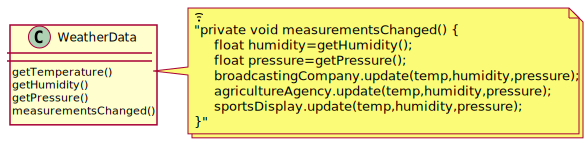

In [6]:
%%plantuml
@startuml
class WeatherData {
    getTemperature()
    getHumidity()
    getPressure()
    measurementsChanged()
}
note right
   <&wifi>
   "private void measurementsChanged() {
        float humidity=getHumidity();
        float pressure=getPressure();
        broadcastingCompany.update(temp,humidity,pressure);
        agricultureAgency.update(temp,humidity,pressure);
        sportsDisplay.update(temp,humidity,pressure);
   }"
end note
@enduml

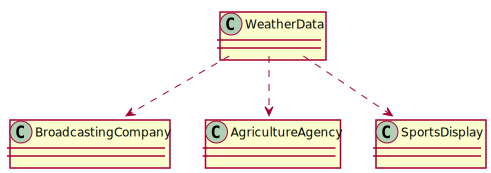

In [7]:
%%plantuml
@startuml
WeatherData ..> BroadcastingCompany
WeatherData ..> AgricultureAgency
WeatherData ..> SportsDisplay
@enduml

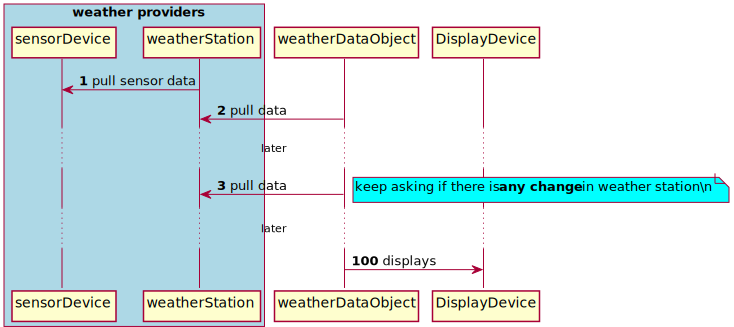

In [8]:
%%plantuml

@startuml

box "weather providers" #LightBlue
  participant sensorDevice
  participant weatherStation
end box

autonumber
sensorDevice <- weatherStation: poll sensor data
weatherStation <- weatherDataObject: poll data
... later ...
weatherStation <- weatherDataObject: poll data

... later ...
autonumber 100
note right #aqua
  keep asking if there is **any change** in weather station\n
end note
weatherDataObject -> DisplayDevice: displays

@enduml

# 4. 설계

* 인터페이스 분리 (ISP Interface Segregation Principle)
* 구체적인 클래스 상속
* 클라이언트는 구체클래스 보다는 추상적 클래스 사용
* Subject
    * Observable, Publisher
    * 상태가 변경이 되면 알림 기능 (notify)
    * 알림 대상이 되는 Observer를 사전에 등록 (register)
* Observers
    * Subscriber
    * Subject의 상태가 변경이 되면 그 내용을 받아서 반영함 (update)


# 5. after

* 데이터를 원하는 display는 등록하고 기다린다
* 통화중이면 전화를 또 걸지 않고 '전화 자동발신'하고 다른 작업을 함

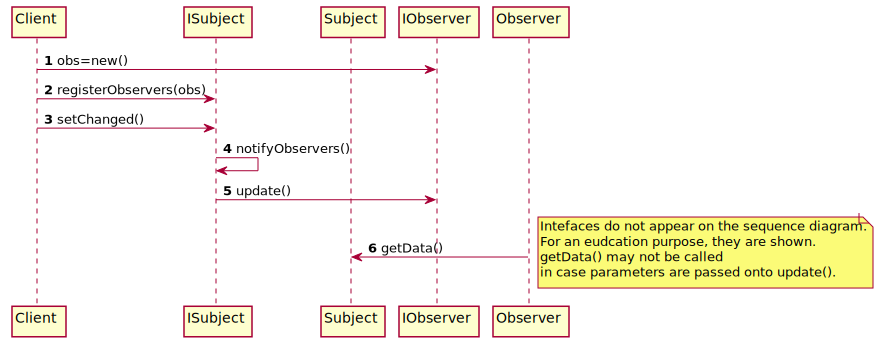

In [6]:
%%plantuml

@startuml
participant Client
participant ISubject
participant Subject
participant IObserver
participant Observer

autonumber
Client -> IObserver:obs=new()
Client -> ISubject:registerObservers(obs)
Client -> ISubject:setChanged()
ISubject -> ISubject:notifyObservers()
ISubject -> IObserver:update()
Observer -> Subject:getData()

note right
    Intefaces do not appear on the sequence diagram.
    For an eudcation purpose, they are shown.
    getData() may not be called
    in case parameters are passed onto update().
end note

@enduml

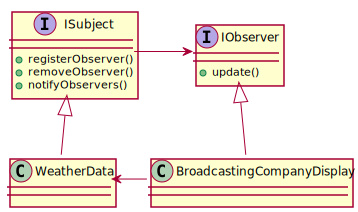

In [11]:
%%plantuml

@startuml

ISubject -right-> IObserver
ISubject <|-- WeatherData
IObserver <|-- BroadcastingCompanyDisplay
WeatherData <-left- BroadcastingCompanyDisplay

Interface ISubject {
    +registerObserver()
    +removeObserver()
    +notifyObservers()
}

Interface IObserver {
    +update()
}
@enduml

# 6. Example

* 객체에서 나누어지는 서로 다른 기능이 있는 경우, 인터페이스로 분리
* 교재 HFDP Ch2 'Weather'

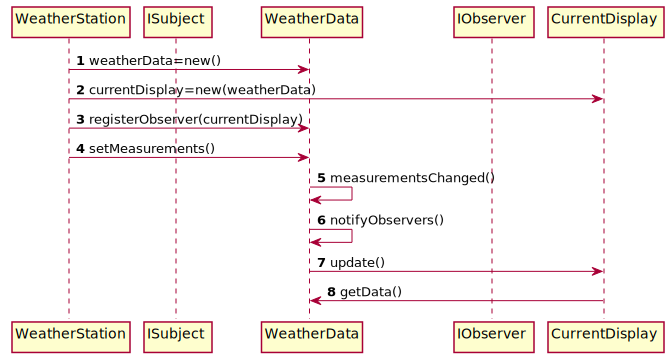

In [12]:
%%plantuml

@startuml
participant WeatherStation
participant ISubject
participant WeatherData
participant IObserver
participant CurrentDisplay

autonumber
WeatherStation -> WeatherData:weatherData=new()
WeatherStation -> CurrentDisplay:currentDisplay=new(weatherData)
WeatherStation -> WeatherData:registerObserver(currentDisplay)
WeatherStation -> WeatherData:setMeasurements()
WeatherData -> WeatherData:measurementsChanged()
WeatherData -> WeatherData:notifyObservers()
WeatherData -> CurrentDisplay:update()
CurrentDisplay -> WeatherData:getData()
@enduml

In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/Subject.java
package headfirst.observer.weather;

public interface Subject {
	public void registerObserver(Observer o);
	public void removeObserver(Observer o);
	public void notifyObservers();
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/Observer.java
package headfirst.observer.weather;

public interface Observer {
	public void update(float temp, float humidity, float pressure);
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/WeatherData.java
package headfirst.observer.weather;

import java.util.*;

public class WeatherData implements Subject {
	private ArrayList observers;
	private float temperature;
	private float humidity;
	private float pressure;
	
	public WeatherData() {
		observers = new ArrayList();
	}
	
	public void registerObserver(Observer o) {
		observers.add(o);
	}
	
	public void removeObserver(Observer o) {
		int i = observers.indexOf(o);
		if (i >= 0) {
			observers.remove(i);
		}
	}
	
	public void notifyObservers() {
		for (int i = 0; i < observers.size(); i++) {
			Observer observer = (Observer)observers.get(i);
			observer.update(temperature, humidity, pressure);
		}
	}
	
	public void measurementsChanged() {
		notifyObservers();
	}
	
	public void setMeasurements(float temperature, float humidity, float pressure) {
		this.temperature = temperature;
		this.humidity = humidity;
		this.pressure = pressure;
		measurementsChanged();
	}
	
	public float getTemperature() {
		return temperature;
	}
	
	public float getHumidity() {
		return humidity;
	}
	
	public float getPressure() {
		return pressure;
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/CurrentConditionsDisplay.java
package headfirst.observer.weather;
	
public class CurrentConditionsDisplay implements Observer, DisplayElement {
	private float temperature;
	private float humidity;
	private Subject weatherData;
	
	public CurrentConditionsDisplay(Subject weatherData) {
		this.weatherData = weatherData;
		weatherData.registerObserver(this);
	}
	
	public void update(float temperature, float humidity, float pressure) {
		this.temperature = temperature;
		this.humidity = humidity;
		display();
	}
	
	public void display() {
		System.out.println("Current conditions: " + temperature 
			+ "F degrees and " + humidity + "% humidity");
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/observer/weather/WeatherStation.java
package headfirst.observer.weather;

import java.util.*;

public class WeatherStation {

	public static void main(String[] args) {
		WeatherData weatherData = new WeatherData();
	
		CurrentConditionsDisplay currentDisplay = 
			new CurrentConditionsDisplay(weatherData);
		StatisticsDisplay statisticsDisplay = new StatisticsDisplay(weatherData);
		ForecastDisplay forecastDisplay = new ForecastDisplay(weatherData);

		weatherData.setMeasurements(80, 65, 30.4f);
		weatherData.setMeasurements(82, 70, 29.2f);
		weatherData.setMeasurements(78, 90, 29.2f);
	}
}


In [ ]:
# %load /Users/media/Code/git/sd/src/headfirst/strategy/FlyRocketPowered.java
package headfirst.strategy;

public class FlyRocketPowered implements FlyBehavior {
	public void fly() {
		System.out.println("I'm flying with a rocket");
	}
}


In [13]:
%pwd

u'/Users/media/Dropbox/Me/toCopy/smu'

In [16]:
# change to the root directory
!javac -d classes/ -sourcepath src src/headfirst/observer/weather/*.java
!java -cp classes/ headfirst.observer.weather.WeatherStation

/Users/media/Code/git/sd
javac: file not found: src/headfirst/observer/weather/*.java
Usage: javac <options> <source files>
use -help for a list of possible options
오류: 기본 클래스 headfirst.observer.weather.WeatherStation을(를) 찾거나 로드할 수 없습니다.
